Example: Known Deflections Model
================================

This example is a continuation of the script `input_deflections_sourre_planes.py`. You should read through that
script if you have not done so already before covering this script.

As we discussed, we can now use an input deflection angle map from an external source to create lensed images of
source galaxies. In this example, we assume the source is not known and something we fit for via lens modeling.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


To begin, we set up the `InputDeflections` object in an identical fashion to the previous example.

In this example, our `input` deflection angle map is the true deflection angles of the `Imaging` data simulated in the 
`mass_sie__source_parametric.py` simulator. You should be able to simply edit the `from_fits` methods below to point
to your own dataset an deflection maps.

Lets load and plot this dataset.

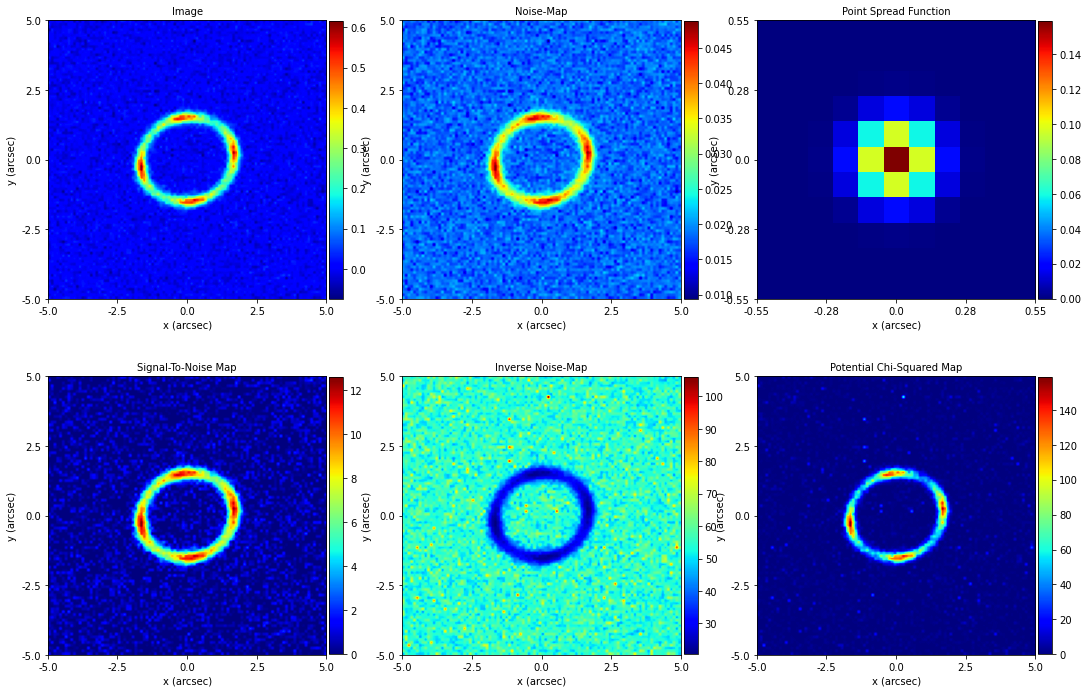

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

In `autolens_workspace/examples/misc/files` you`ll find the script `make_source_plane.py`, which creates the image-plane 
`Grid2D` and deflection angles we use in this example (which are identical to those used in the 
`mass_sie__source_parametric.py` simulator). 

Lets load the input deflection angle map from a .fits files (which is created in the code mentioned above).

In [3]:
deflections_y = al.Array2D.from_fits(
    file_path=path.join("dataset", "misc", "deflections_y.fits"),
    pixel_scales=imaging.pixel_scales,
)
deflections_x = al.Array2D.from_fits(
    file_path=path.join("dataset", "misc", "deflections_x.fits"),
    pixel_scales=imaging.pixel_scales,
)

Lets plot the deflection angles to make sure they look like what we expect!

In [4]:
aplt.Array2DPlotter(array=deflections_y)
aplt.Array2DPlotter(array=deflections_x)

Lets next load and plot the image-plane grid

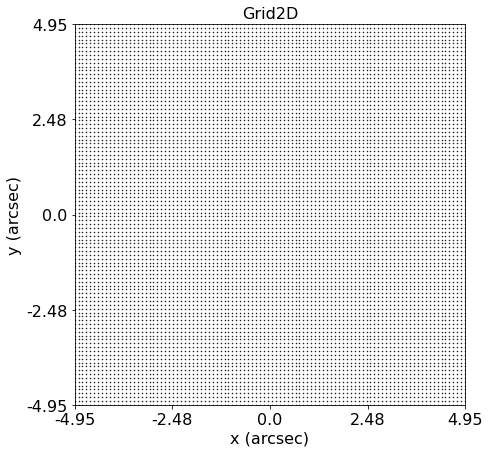

In [5]:
grid = al.Grid2D.from_fits(
    file_path=path.join("dataset", "misc", "grid.fits"),
    pixel_scales=imaging.pixel_scales,
)
grid_plotter = aplt.Grid2DPlotter(grid=grid)
grid_plotter.figure_2d()

The `Mask2D` our model-fit using the `InputDeflections` will use. This is set up the same way as the previous script, but
not this `Mask2D` now defines the image-plane region we will fit the data (and therefore where our residuals, chi-squared,
likelihood, etc is calculated.

In [6]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

grid = al.Grid2D.from_mask(mask=mask)

imaging = imaging.apply_mask(mask=mask)

We create the `InputDeflections` `MassProfile`.almosst the same as the previous example. This is going to be passed to 
a  `Model` below, so we can use it with a source model to fit to the `Imaging` data using a non-linear search.

However, we pass two additional parameters, `preload_grid` and `preload_blurring_grid`. 

The interpolation performed by the `InputDeflections` can be computationally slow, and if we did it for every 
lens model we fit to the data we`d waste a lot of time. However, because our deflection angle map is fixed and the 
`grid` and `blurring_grid` we interpolated it to are fixed, by passing the latter as a `preload_grid` we can skip
this expensive repeated calculation and speed up the code significantly. Yay!

In [7]:
image_plane_grid = al.Grid2D.uniform(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales
)
input_deflections = al.mp.InputDeflections(
    deflections_y=deflections_y,
    deflections_x=deflections_x,
    image_plane_grid=image_plane_grid,
    preload_grid=grid,
    preload_blurring_grid=al.Grid2D.blurring_grid_from_mask_and_kernel_shape(
        mask=mask, kernel_shape_native=imaging.psf.shape_native
    ),
)

__Model__

We now compose the lens and source `Model`, where the source is an `EllSersic`.

In [8]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=input_deflections)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search__

The source is fitted to the `Imaging` data via the input deflection angles using a non-linear search, which we 
specify below as the nested sampling algorithm Dynesty (https://dynesty.readthedocs.io/en/latest/). Checkout 
other examples on the workspace if you are unsure what this does!

The script `autolens_workspace/notebooks/modeling/customize/non_linear_searches.py` gives a description of the types of
non-linear searches that **PyAutoLens** supports. If you do not know what a non-linear search is or how it 
operates, checkout chapters 1 and 2 of the HowToLens lecture series.

In [9]:
search = af.DynestyStatic(
    path_prefix=path.join("misc"),
    name="search__input_deflections",
    unique_tag=dataset_name,
    nlive=100,
)

__Analysis__

The `AnalysisImaging` object defines the `log_likelihood_function` used by the non-linear search to fit the model to 
the `Imaging`dataset.

In [10]:
analysis = al.AnalysisImaging(dataset=imaging)

__Model-Fit__

We can now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear
search to find which models fit the data with the highest likelihood.

Checkout the folder `autolens_workspace/output/imaging/mass_sie__source_sersic/mass[sie]_source[bulge]` for live outputs 
of the results of the fit, including on-the-fly visualization of the best fit model!

In [11]:
result = search.fit(model=model, analysis=analysis)

2021-05-10 15:52:29,985 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  7.19it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
2021-05-10 15:52:30,288 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:52:30,401 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:52:30,495 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


Finish.